# Stereo Calibration Workflow

## Chessboard

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [50]:
path = list(Path("images/").glob("left*.webp"))
print(path)
imgs_l = []

for p in path:
    print(p)
    im = cv2.imread(str(p),0)
    imgs_l.append(im)
    
imgs_l.pop(1)
print(len(imgs_l))

[WindowsPath('images/left01.webp'), WindowsPath('images/left02.webp'), WindowsPath('images/left03.webp'), WindowsPath('images/left04.webp')]
images\left01.webp
images\left02.webp
images\left03.webp
images\left04.webp
3


In [51]:
path = list(Path("images/").glob("right*.webp"))
print(path)
imgs_r = []

for p in path:
    print(p)
    im = cv2.imread(str(p),0)
    imgs_r.append(im)

imgs_r.pop(1)
print(len(imgs_r))

[WindowsPath('images/right01.webp'), WindowsPath('images/right02.webp'), WindowsPath('images/right03.webp'), WindowsPath('images/right04.webp')]
images\right01.webp
images\right02.webp
images\right03.webp
images\right04.webp
3


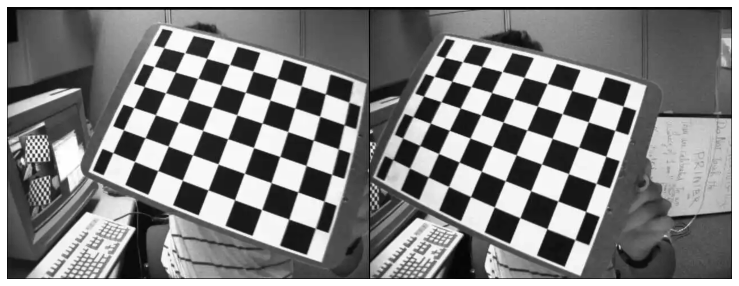

In [52]:
plt.figure(figsize=(15,5))
num = 1
plt.imshow(np.hstack((imgs_l[num],imgs_r[num])), cmap="gray")
plt.axis("off");

In [74]:
def objectPoints(marker_size, marker_scale):
        """
        Returns a set of the target's ideal 3D feature points.
        """
        objp = np.zeros((np.prod(marker_size), 3), np.float32)
        objp[:, :2] = np.indices(marker_size).T.reshape(-1, 2)*marker_scale
        return objp

def findCorners(im):
    flags = 0
    flags |= cv2.CALIB_CB_ADAPTIVE_THRESH
    flags |= cv2.CALIB_CB_FAST_CHECK
    flags |= cv2.CALIB_CB_NORMALIZE_IMAGE

    # ok,gray = cv2.threshold(gray,90,255,cv2.THRESH_BINARY)

    ok, corners = cv2.findChessboardCorners(
        im,
        (6,9),
        flags=flags)
    
    print("Image")
    print(f"  ok: {ok}")
    print(f"  find corners: {corners.shape}")
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
    corners = cv2.cornerSubPix(im, corners, (11,11), (-1,-1), criteria)
    
    print(f"  subpix corners: {corners.shape}")
    
    return corners
    

In [80]:
corners_l = []

for im in imgs_l:
    c = findCorners(im)
    # imgpoints.append(corners.reshape(-1, 2))
    corners_l.append(c)
print(f"corners_l: list length {len(corners_l)}")

Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
corners_l: list length 3


In [81]:
corners_r = []

for im in imgs_r:
    c = findCorners(im)
    corners_r.append(c)
print(f"corners_r: list length {len(corners_r)}")

Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
Image
  ok: True
  find corners: (54, 1, 2)
  subpix corners: (54, 1, 2)
corners_r: list length 3


In [83]:
objpts = objectPoints((6,9), 0.02)
print(f"objpts: {objpts.shape}")
objpoints = [objpts]*len(corners_l)
print(f"objpoints: list length {len(objpoints)}")

objpts: (54, 3)
objpoints: list length 3


In [85]:
h,w = imgs_l[0].shape[:2]
rms, K1, d1, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors = cv2.calibrateCameraExtended(
            objpoints, corners_l, (w, h), None, None)
print("left:", rms)
rms, K2, d2, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors = cv2.calibrateCameraExtended(
            objpoints, corners_r, (w, h), None, None)
print("right", rms)

left: 0.16484923410381744
right 0.3055641309926919


In [86]:
stereocalib_criteria = (
            cv2.TERM_CRITERIA_MAX_ITER +
            cv2.TERM_CRITERIA_EPS,
            100,
            1e-5)

ret, K1, d1, K2, d2, R, T, E, F = cv2.stereoCalibrate(
            objpoints,
            corners_l,
            corners_r,
            K1, d1,
            K2, d2,
            (w,h),
            # (h,w),
            # R=self.R,
            # T=self.t,
            # R=np.eye((3,3)),
            # T=np.array([[0.031],[0],[0]]), # FIXME
            criteria=stereocalib_criteria,
            flags=None)

print(K1)
print(K2)

[[538.04219922   0.         333.97848102]
 [  0.         538.18765688 233.34746759]
 [  0.           0.           1.        ]]
[[541.44342245   0.         320.01856629]
 [  0.         541.75279801 246.50200836]
 [  0.           0.           1.        ]]


## Apriltag

In [87]:
import cv2.aruco as aruco

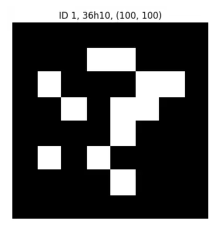

In [95]:
im = cv2.imread("apriltags/apriltag.webp",0)

plt.imshow(im, cmap="gray")
plt.axis("off");

In [96]:
corners, ids, rejectedImgPts = aruco.detectMarkers(
    im,
    aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10), 
    parameters=aruco.DetectorParameters_create(),
)

print(corners)
print(ids)

(array([[[ 10.,  31.],
        [379.,  31.],
        [379., 400.],
        [ 10., 400.]]], dtype=float32),)
[[1]]


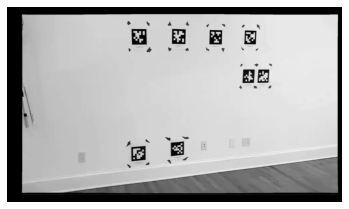

In [98]:
multi = cv2.imread("apriltags/multiple-tags.webp",0)

plt.imshow(multi, cmap="gray")
plt.axis("off");

In [108]:
corners, ids, rejectedImgPts = aruco.detectMarkers(
    multi,
    aruco.Dictionary_get(aruco.DICT_APRILTAG_36h11), 
    parameters=aruco.DetectorParameters_create(),
)

print(len(corners), corners[0].shape)
print(ids)

# c = [c.reshape((-1,2)) for c in corners]
c = []
for m in corners:
    for crn in m:
        for pt in crn:
            c.append([pt])
        
c = np.array(c)
c.shape # 8 imgs * 4 corners = 32 points of size 1x2

8 (1, 4, 2)
[[5]
 [6]
 [8]
 [7]
 [3]
 [2]
 [0]
 [1]]


(32, 1, 2)

In [121]:
cc = corners[0]
print(cc.shape)
# print(cc)

ccc = cc.reshape((4,1,2))
print(ccc.shape)
ccc

(1, 4, 2)
(4, 1, 2)


array([[[418., 462.]],

       [[375., 467.]],

       [[374., 426.]],

       [[418., 421.]]], dtype=float32)

In [128]:
print(corners_r[0].shape)
# corners_r[0]

(54, 1, 2)


In [126]:
def aruco2opencv(corners):
    """
    Takes corners found from cv2.aruco.detectMarkers() which is a list
    of markers size (1,4,2) each and returns
    a numpy array of (4*markers,1,2) where each marker has 4 corners
    and if there are 6 markers in the image, then the first number
    is 4*6 = 24 or (24,1,2). This is what is passed to cv2.cornerSubPix
    or cv2.calibrateCamera() / cv2.calibrateStereo()
    """
    c = [x.reshape((4,1,2)) for x in corners]
    c = np.vstack(c)
    return c

c = aruco2opencv(corners)
c.shape

(32, 1, 2)

In [127]:
len(corners)

8

In [1]:
sorted([2,1,3])

[1, 2, 3]